Data: Combined with added features , Shades and Radiation. <br>
Split: Train, Validate, Test

# 1. Import Library - Load Data - Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# models
from sklearn.ensemble import RandomForestRegressor

# explain
from sklearn.tree import export_graphviz

from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
## FUNCTIONS USED IN NOTEBOOK ##

def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [3]:
# filepath_summer = "/Users/alialyakoob/Dropbox/Mac/Desktop/ASU/RA/Data/Model_Data/microclimate_model/Combined/Summer Days/summer_limited2.csv"
# filepath_june9_trees = "/Users/alialyakoob/Dropbox/Mac/Desktop/ASU/RA/Data/Model_Data/microclimate_model/Combined/Trees_Scenario/June_9_trees.csv"
# filepath_bldg1 = "/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/all_buildings_limited.csv"

filepath_summer = "././Data/microclimate_model/Combined/summer_limited2.csv"
filepath_june9_trees = "././Data/microclimate_model/Combined/June_9_trees.csv"
filepath_bldg1 = "././Data/microclimate_model/Combined/all_buildings_limited.csv"

In [4]:
Bldg = pd.read_csv(filepath_summer)
Bldg = Bldg.drop(columns = ['Unnamed: 0','CHWTON'])
Bldg['Date_Time'] = pd.to_datetime(Bldg['Date_Time'])


In [5]:
Tree_X = pd.read_csv(filepath_june9_trees)
Tree_X = Tree_X.drop(columns = ['Unnamed: 0','CHWTON','CHWTON/SQFT' ])
Tree_X['Date_Time'] = pd.to_datetime(Tree_X['Date_Time'])
Tree_X.set_index(Tree_X['Date_Time'], inplace=True)

# 2. Data Visualization

In [6]:
# Add CHWTON/SQM 
Bldg['CHWTON/SQM'] = Bldg['CHWTON/SQFT']/0.092903


In [7]:
Bldg.info()
Bldg.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9749 entries, 0 to 9748
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   bldgname     9749 non-null   object        
 1   Date_Time    9749 non-null   datetime64[ns]
 2   Month        9749 non-null   int64         
 3   Day          9749 non-null   int64         
 4   Hour         9749 non-null   int64         
 5   Minute       9749 non-null   int64         
 6   Air Temp     9749 non-null   float64       
 7   Abs Hum      9749 non-null   float64       
 8   Rel Hum      9749 non-null   float64       
 9   DSW Top      9749 non-null   float64       
 10  DSW North    9749 non-null   float64       
 11  DSW East     9749 non-null   float64       
 12  DSW South    9749 non-null   float64       
 13  DSW West     9749 non-null   float64       
 14  Shade North  9749 non-null   float64       
 15  Shade East   9749 non-null   float64       
 16  Shade 

Month          Day         Hour       Minute     Air Temp  \
count  9749.000000  9749.000000  9749.000000  9749.000000  9749.000000   
mean      6.099600    14.583957    12.365986    22.451533    34.874594   
std       0.949499     9.529819     4.617301    16.778868     4.878771   
min       5.000000     1.000000     5.000000     0.000000    21.220711   
25%       5.000000     7.000000     8.000000     0.000000    31.416979   
50%       6.000000    16.000000    12.000000    15.000000    35.814891   
75%       6.000000    23.000000    16.000000    30.000000    38.907194   
max       8.000000    28.000000    20.000000    45.000000    43.284562   

           Abs Hum      Rel Hum      DSW Top    DSW North     DSW East  \
count  9749.000000  9749.000000  9749.000000  9749.000000  9749.000000   
mean      6.145771    16.156785   514.703641    21.860936   139.325408   
std       2.914697     8.043260   382.861035    38.579683   204.241050   
min       2.892712     5.682219     0.000000     0.000000     0.000000   
25%       4.281997     9.420316   104.909120     0.000000     0.000000   
50%       5.208316    13.247575   552.475568     0.000000     0.000000   
75%       6.727830    21.616531   896.115445    30.810642   259.920407   
max      16.642184    45.117368  1060.599716   189.329186   768.360009   

         DSW South     DSW West  Shade North   Shade East  Shade South  \
count  9749.000000  9749.000000  9749.000000  9749.000000  9749.000000   
mean     53.424433   127.653171     0.818981     0.748601     0.659623   
std      73.784326   200.249310     0.283898     0.340883     0.391952   
min       0.000000     0.000000     0.022727     0.000000     0.000000   
25%       0.000000     0.000000     0.639118     0.466011     0.241584   
50%       0.000000     0.000000     1.000000     1.000000     1.000000   
75%     111.715486   239.693169     1.000000     1.000000     1.000000   
max     288.530792   765.035686     1.000000     1.000000     1.000000   

        Shade West           KW  CHWTON/SQFT      HTmmBTU   CHWTON/SQM  
count  9749.000000  9749.000000  9749.000000  9749.000000  9749.000000  
mean      0.765117   358.399651     0.002678     0.231643     0.028823  
std       0.330920   275.140547     0.001605     0.301404     0.017277  
min       0.006623    51.920000     0.000144    -0.010000     0.001550  
25%       0.462615   138.440000     0.001422     0.010000     0.015305  
50%       1.000000   212.230000     0.002312     0.120000     0.024888  
75%       1.000000   548.740000     0.003634     0.290000     0.039112  
max       1.000000  1054.010000     0.008456     1.600000     0.091024

In [8]:
Bldg.columns

Index(['bldgname', 'Date_Time', 'Month', 'Day', 'Hour', 'Minute', 'Air Temp',
       'Abs Hum', 'Rel Hum', 'DSW Top', 'DSW North', 'DSW East', 'DSW South',
       'DSW West', 'Shade North', 'Shade East', 'Shade South', 'Shade West',
       'KW', 'CHWTON/SQFT', 'HTmmBTU', 'CHWTON/SQM'],
      dtype='object')

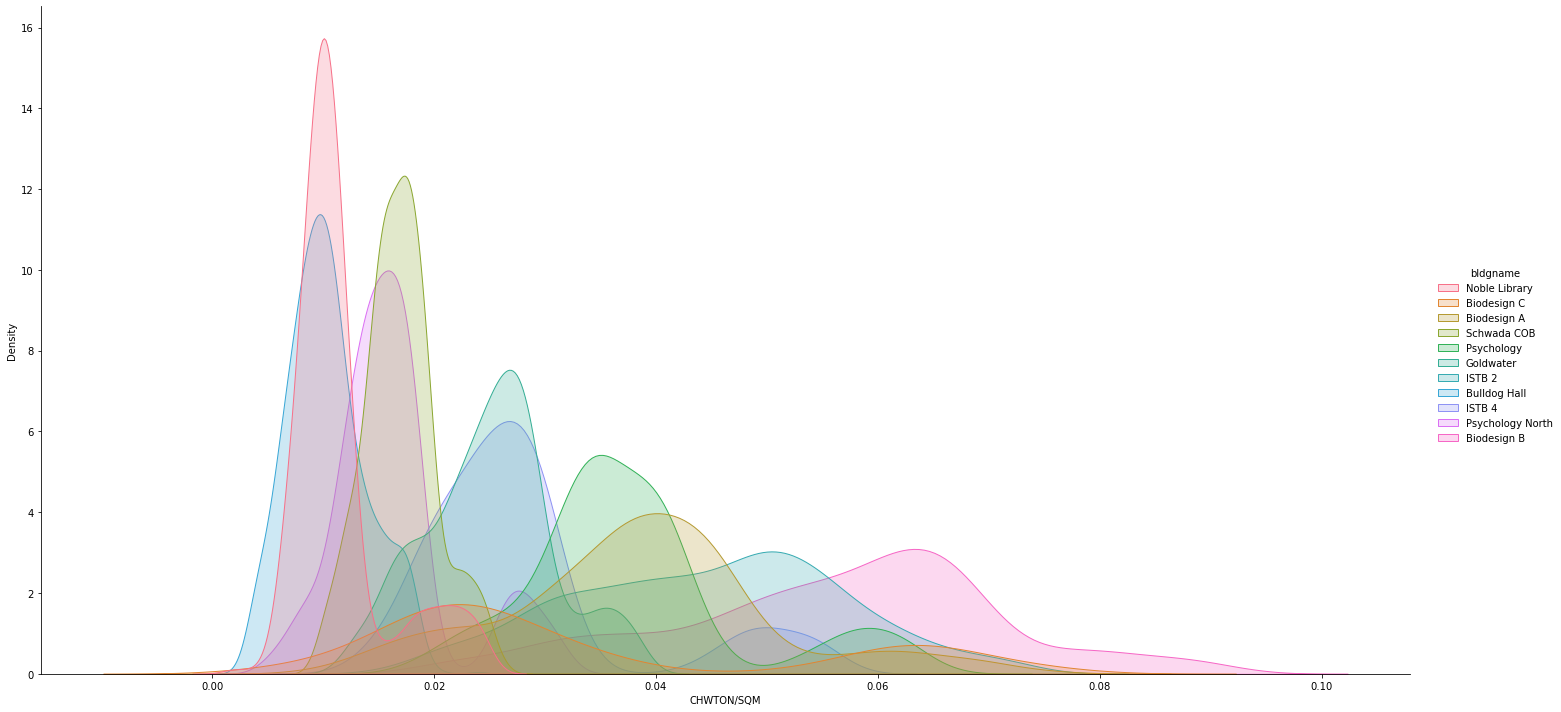

In [9]:
sns.displot(Bldg, x="CHWTON/SQM", hue="bldgname", kind="kde", fill=True, height=10, aspect=2)

<AxesSubplot:>

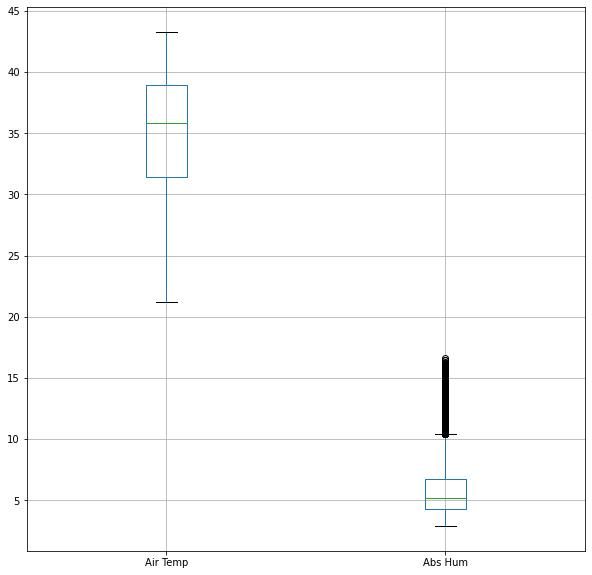

In [10]:
plt.figure(figsize=(10, 10))
Bldg[['Air Temp', 'Abs Hum']].boxplot()

Set Date_Time as index

In [11]:
Bldg.set_index(Bldg['Date_Time'], inplace=True)

In [12]:
b = Bldg[(Bldg['bldgname'] == 'ISTB 4') | (Bldg['bldgname'] == 'Psychology' )
        | (Bldg['bldgname'] == 'Psychology North')]

In [13]:
b[b['bldgname'] == 'ISTB 4']

bldgname           Date_Time  Month  Day  Hour  Minute  \
Date_Time                                                                    
2018-05-10 05:00:00   ISTB 4 2018-05-10 05:00:00      5   10     5       0   
2018-05-10 05:15:00   ISTB 4 2018-05-10 05:15:00      5   10     5      15   
2018-05-10 05:30:00   ISTB 4 2018-05-10 05:30:00      5   10     5      30   
2018-05-10 05:45:00   ISTB 4 2018-05-10 05:45:00      5   10     5      45   
2018-05-10 06:00:00   ISTB 4 2018-05-10 06:00:00      5   10     6       0   
...                      ...                 ...    ...  ...   ...     ...   
2018-08-03 19:45:00   ISTB 4 2018-08-03 19:45:00      8    3    19      45   
2018-08-03 20:00:00   ISTB 4 2018-08-03 20:00:00      8    3    20       0   
2018-08-03 20:15:00   ISTB 4 2018-08-03 20:15:00      8    3    20      15   
2018-08-03 20:30:00   ISTB 4 2018-08-03 20:30:00      8    3    20      30   
2018-08-03 20:45:00   ISTB 4 2018-08-03 20:45:00      8    3    20      45   

                      Air Temp    Abs Hum    Rel Hum    DSW Top  ...  \
Date_Time                                                        ...   
2018-05-10 05:00:00  27.227816   4.546180  17.428702   0.000000  ...   
2018-05-10 05:15:00  26.588722   4.939002  19.617430   0.000000  ...   
2018-05-10 05:30:00  26.395403   4.852056  19.480385   0.000000  ...   
2018-05-10 05:45:00  26.257381   4.833794  19.556790   0.000000  ...   
2018-05-10 06:00:00  26.117413   4.815478  19.635286  10.850973  ...   
...                        ...        ...        ...        ...  ...   
2018-08-03 19:45:00  40.028221  10.196667  19.926112   0.000000  ...   
2018-08-03 20:00:00  39.914039  10.238963  20.123633   0.000000  ...   
2018-08-03 20:15:00  39.779931  10.286035  20.352657   0.000000  ...   
2018-08-03 20:30:00  39.675349  10.341445  20.570063   0.000000  ...   
2018-08-03 20:45:00  39.557193  10.399286  20.808340   0.000000  ...   

                     DSW South  DSW West  Shade North  Shade East  \
Date_Time                                                           
2018-05-10 05:00:00        0.0       0.0     1.000000    1.000000   
2018-05-10 05:15:00        0.0       0.0     1.000000    1.000000   
2018-05-10 05:30:00        0.0       0.0     1.000000    1.000000   
2018-05-10 05:45:00        0.0       0.0     1.000000    1.000000   
2018-05-10 06:00:00        0.0       0.0     0.553997    0.339222   
...                        ...       ...          ...         ...   
2018-08-03 19:45:00        0.0       0.0     1.000000    1.000000   
2018-08-03 20:00:00        0.0       0.0     1.000000    1.000000   
2018-08-03 20:15:00        0.0       0.0     1.000000    1.000000   
2018-08-03 20:30:00        0.0       0.0     1.000000    1.000000   
2018-08-03 20:45:00        0.0       0.0     1.000000    1.000000   

                     Shade South  Shade West      KW  CHWTON/SQFT  HTmmBTU  \
Date_Time                                                                    
2018-05-10 05:00:00          1.0         1.0  909.29     0.001702     1.04   
2018-05-10 05:15:00          1.0         1.0  909.78     0.001784     1.09   
2018-05-10 05:30:00          1.0         1.0  914.66     0.001617     1.02   
2018-05-10 05:45:00          1.0         1.0  898.77     0.001711     1.04   
2018-05-10 06:00:00          1.0         1.0  892.68     0.001589     1.07   
...                          ...         ...     ...          ...      ...   
2018-08-03 19:45:00          1.0         1.0  947.53     0.004452     0.99   
2018-08-03 20:00:00          1.0         1.0  946.75     0.004434     0.99   
2018-08-03 20:15:00          1.0         1.0  940.84     0.004396     0.98   
2018-08-03 20:30:00          1.0         1.0  941.89     0.004467     0.95   
2018-08-03 20:45:00          1.0         1.0  947.05     0.004400     1.03   

                     CHWTON/SQM  
Date_Time                        
2018-05-10 05:00:00    0.018324  
2018-05-10 05:15:00    0.019205  
2018-05-10 05:30:00

Visualize Time Series By Day

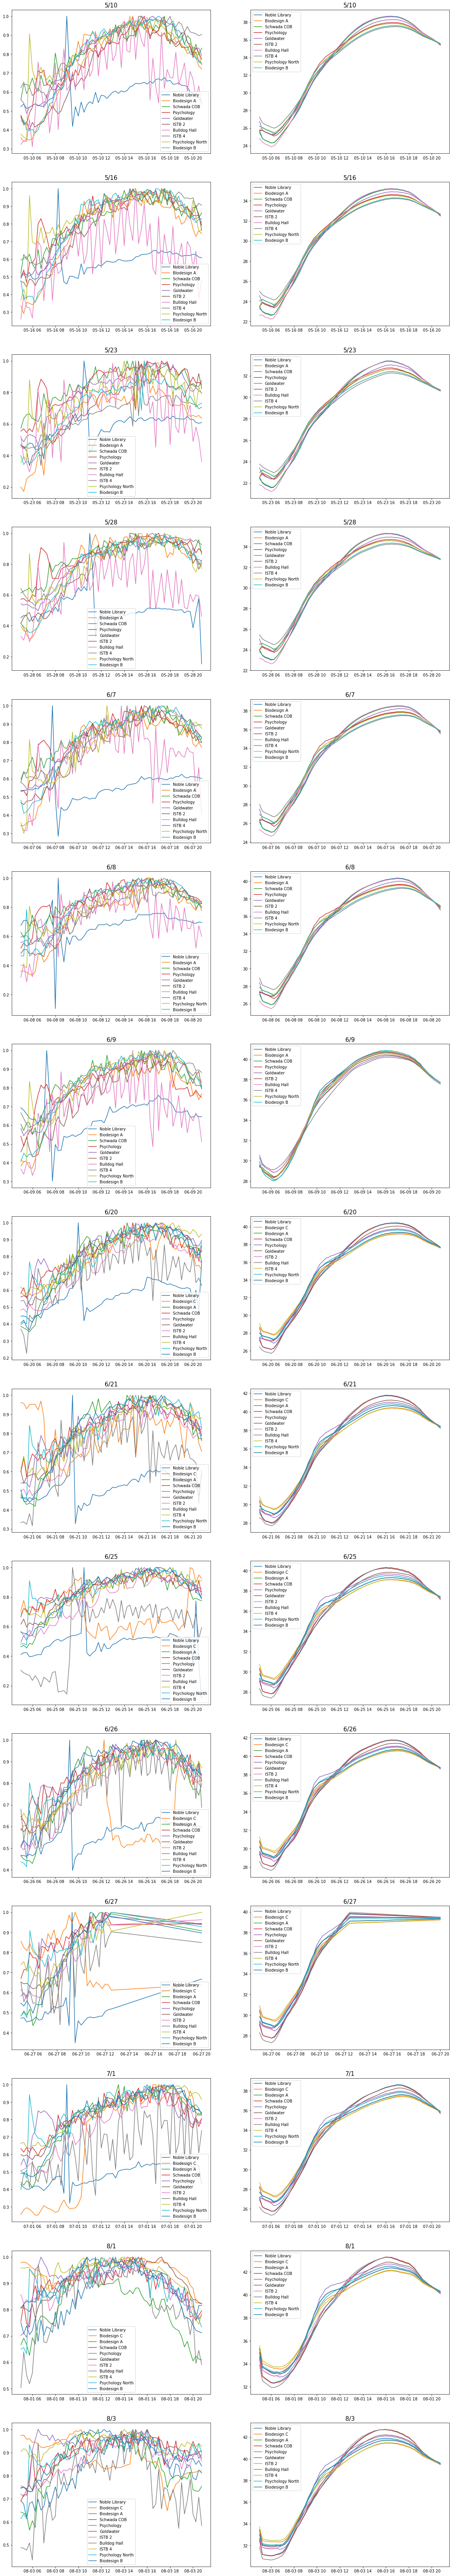

In [14]:
fig, ax = plt.subplots(15,2,figsize=(20,120))
b = Bldg
counter = -1
for i in b['Month'].unique():
    m = b[(b['Month'] == i)]
    for z in m['Day'].unique():
        d = m[(m['Day'] == z)]
        counter+=1
        for un in d['bldgname'].unique():
            bl = d[(d['bldgname'] == un)]
            ax[counter,0].plot((bl['CHWTON/SQM']/bl['CHWTON/SQM'].max()), label = bl['bldgname'][0])
            ax[counter,0].set_title(str(bl['Month'].iloc[0]) + '/' + str(bl['Day'].iloc[0]), fontsize = 15)
            ax[counter,0].legend()
            ax[counter,1].plot(bl['Air Temp'], label = bl['bldgname'][0])
            ax[counter,1].set_title(str(bl['Month'].iloc[0]) + '/' + str(bl['Day'].iloc[0]), fontsize = 15)
            ax[counter,1].legend()

Clean Data based on Visualization

In [15]:
Bldg = Bldg.drop(Bldg.loc[pd.date_range('2018-06-27 05:00:00','2018-06-27 12:30:00', freq = '15min')].index)
Bldg = Bldg.drop(Bldg.loc[pd.date_range('2018-08-01 05:00:00','2018-08-01 20:45:00', freq = '15min')].index)
Bldg = Bldg.drop(Bldg.loc[pd.date_range('2018-08-03 05:00:00','2018-08-03 20:45:00', freq = '15min')].index)
Bldg = Bldg.drop(Bldg.loc[pd.Timestamp('2018-06-27 20:00:00')].index)
Bldg = Bldg[Bldg['bldgname'] != 'Biodesign C']
Bldg = Bldg[Bldg['bldgname'] != 'Noble Library']
Bldg = Bldg[Bldg['bldgname'] != 'Bulldog Hall']

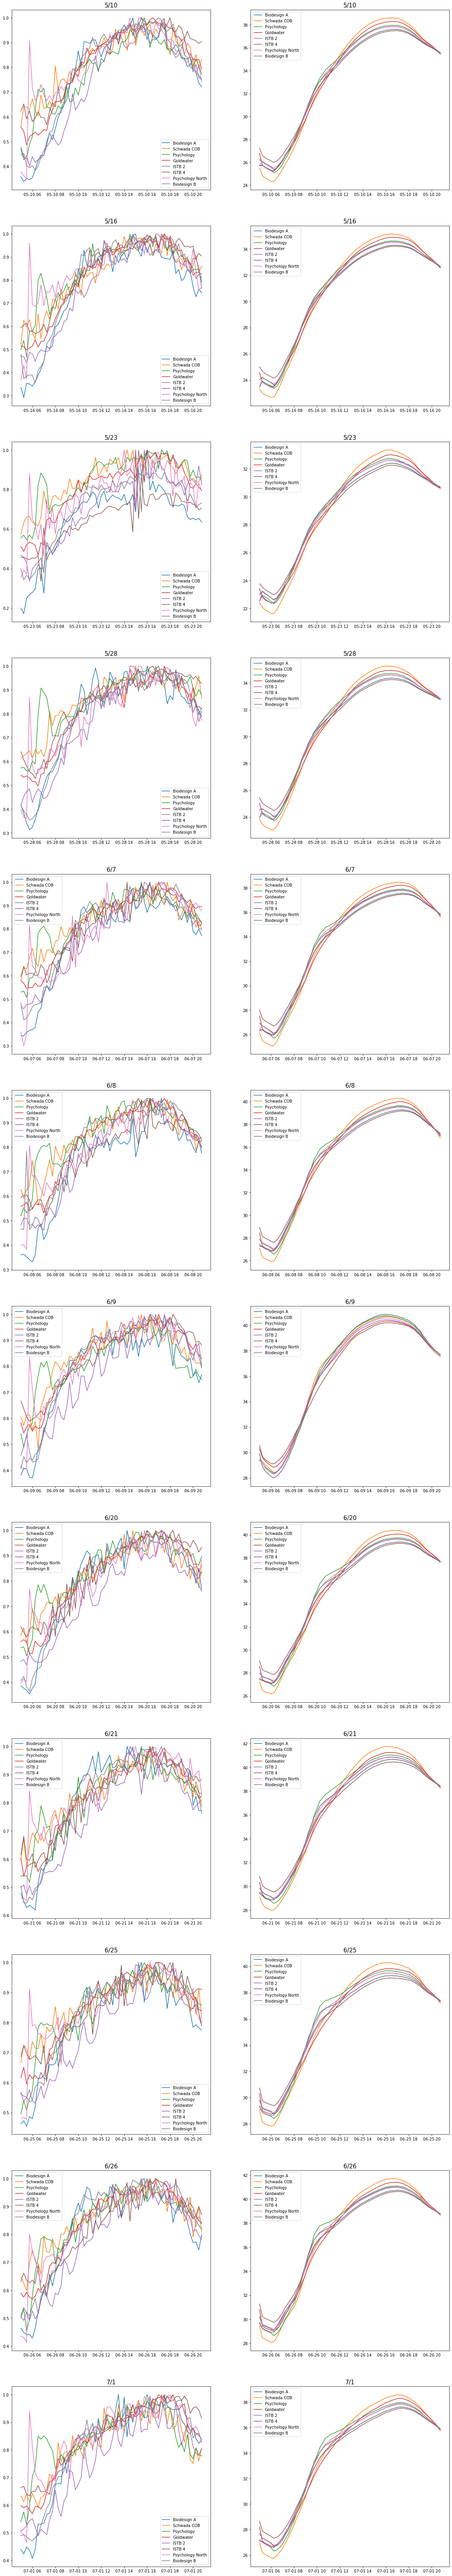

In [16]:
fig, ax = plt.subplots(12,2,figsize=(20,120))
b = Bldg
counter = -1
for i in b['Month'].unique():
    m = b[(b['Month'] == i)]
    for z in m['Day'].unique():
        d = m[(m['Day'] == z)]
        counter+=1
        for un in d['bldgname'].unique():
            bl = d[(d['bldgname'] == un)]
            ax[counter,0].plot((bl['CHWTON/SQM']/bl['CHWTON/SQM'].max()), label = bl['bldgname'][0])
            ax[counter,0].set_title(str(bl['Month'].iloc[0]) + '/' + str(bl['Day'].iloc[0]), fontsize = 15)
            ax[counter,0].legend()
            ax[counter,1].plot(bl['Air Temp'], label = bl['bldgname'][0])
            ax[counter,1].set_title(str(bl['Month'].iloc[0]) + '/' + str(bl['Day'].iloc[0]), fontsize = 15)
            ax[counter,1].legend()

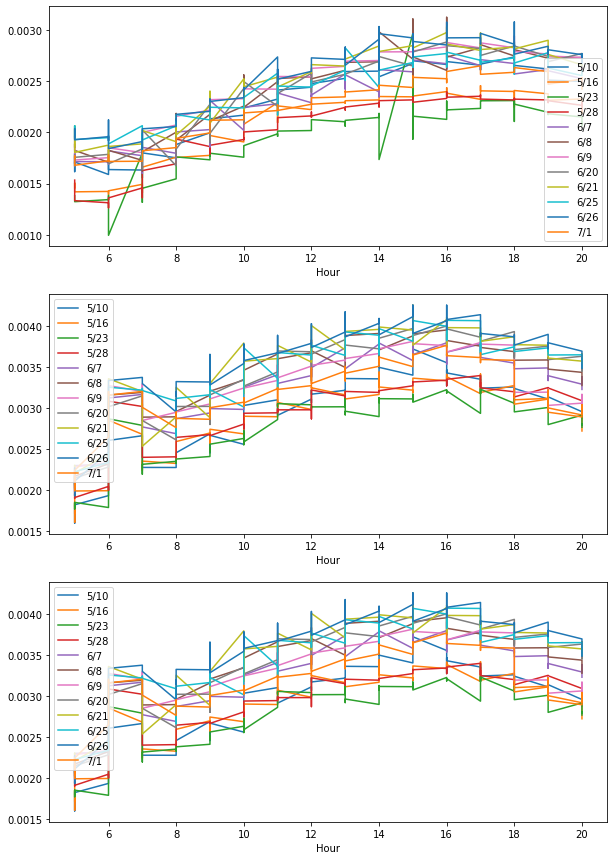

In [17]:
fig, axes = plt.subplots(3,1,figsize=(10,15))

for i in b['Month'].unique():
    m = b[(b['Month'] == i)]
    for z in m['Day'].unique():
        d = m[(m['Day'] == z)]
        d[d['bldgname'] == 'ISTB 4'].plot(y = 'CHWTON/SQFT', x = 'Hour', ax = axes[0], label = str(d['Month'][0]) + '/' + str(d['Day'][0]));
        d[d['bldgname'] == 'Psychology'].plot(y = 'CHWTON/SQFT', x = 'Hour', ax = axes[1], label = str(d['Month'][0]) + '/' + str(d['Day'][0]));
        d[d['bldgname'] == 'Psychology'].plot(y = 'CHWTON/SQFT', x = 'Hour', ax = axes[2], label = str(d['Month'][0]) + '/' + str(d['Day'][0]));

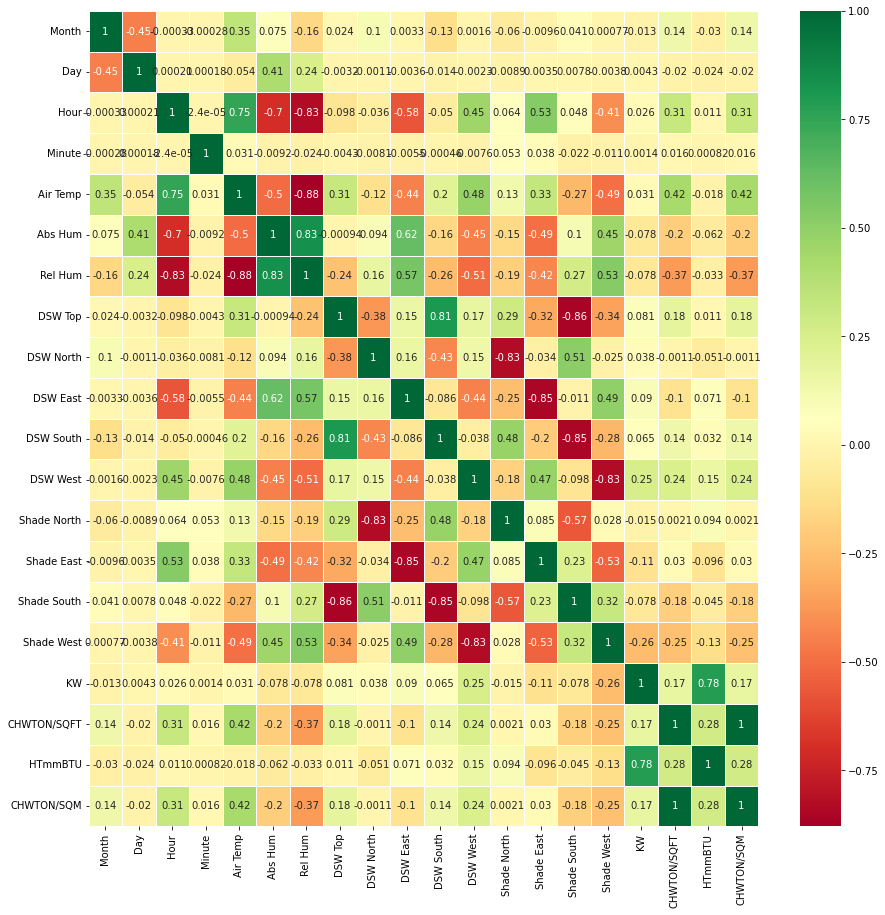

In [18]:
corrMatrix = Bldg.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, cmap='RdYlGn', annot = True, linewidths = 1)
plt.show()

In [19]:
## CHOOSE Y TO PLOT ##
# >> NameError: name 'J9' is not defined
# y = 'HTmmBTU'
# df = J9.copy()
# df = undummify(df)
# for i in df['bldgname'].unique():
#     b = df[df['bldgname'] == i]
#     c = undummify(Scen1)
#     c = (c[c['bldgname'] == i])
#     ax = b.plot(y = y, label = "Baseline", 
#                 ylabel = y, title = i)
#     c.plot(y = y, label = "Scenario",
#          ylabel = y, ax=ax)

# 3. Random Forests Model

In [20]:
### PREPROCESSING DATA FOR MODEL ###
# , 'DSW Top', 'DSW North','DSW East','DSW South','DSW West'
MD = Bldg.copy()
# Remove Columns
MD = MD.drop(columns = ['Rel Hum', 'Minute','CHWTON/SQFT'])

# Select ISTB4, Psychology, and Psychology North
MD = MD[(MD['bldgname'] == 'ISTB 4') | (MD['bldgname'] == 'Psychology') | (MD['bldgname'] == 'Psychology North')]

# One hot encode building names
MD = pd.get_dummies(MD)
# Remove June 9 from data and save to new df
J9 = MD.loc['2018-06-09']
MD.drop(MD[(MD['Day'] == 9) & (MD['Month'] == 6)].index, inplace = True)
# Check if June 9 data is still in MD
MD.loc['2018-06-09']

Empty DataFrame
Columns: [Date_Time, Month, Day, Hour, Air Temp, Abs Hum, DSW Top, DSW North, DSW East, DSW South, DSW West, Shade North, Shade East, Shade South, Shade West, KW, HTmmBTU, CHWTON/SQM, bldgname_ISTB 4, bldgname_Psychology, bldgname_Psychology North]
Index: []

[0 rows x 21 columns]

## 3.1 Export train and test datas as csv

In [21]:
# export MD as csv
dropcols = ['Date_Time', 'Month', 'Hour', 'Day']
MD_export =  MD.drop(columns=dropcols)
train_filepath ="././Data/microclimate_model/Combined/three_bldgs_dropped.csv"
MD_export.to_csv(train_filepath)

# export J9 as csv
test_filepath ="././Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"
J9_export = J9.drop(columns=dropcols)
J9_export.to_csv(test_filepath)

In [22]:
# Grab 3 buuldings data
Psyc = J9[J9['bldgname_Psychology'] == 1]
Psyc_N = J9[J9['bldgname_Psychology North'] == 1]
ISTB4  = J9[J9['bldgname_ISTB 4'] == 1]

<AxesSubplot:title={'center':'Absolute Humidity - June 9, 2018'}, xlabel='Time', ylabel='Abs Hum'>

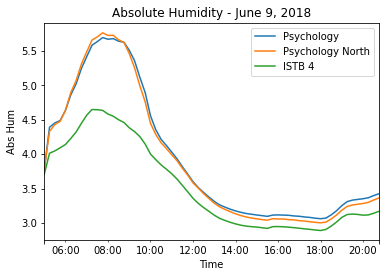

In [23]:
# Plot abs humidity for the 3 bldgs
fig, ax = plt.subplots()
yplot = 'Abs Hum'
ylab = 'Abs Hum'
title = 'Absolute Humidity - June 9, 2018'
Psyc.plot(x = 'Date_Time', y = yplot, label = 'Psychology', xlabel = 'Time', ylabel = ylab, title = title,ax = ax)
Psyc_N.plot(x = 'Date_Time', y = yplot, label = 'Psychology North', xlabel = 'Time', ylabel = ylab, ax = ax)
ISTB4.plot(x = 'Date_Time', y = yplot, label = 'ISTB 4', xlabel = 'Time', ylabel = ylab, ax = ax)

<AxesSubplot:title={'center':'Air Temperature - June 9, 2018'}, xlabel='Time', ylabel='Air Temp'>

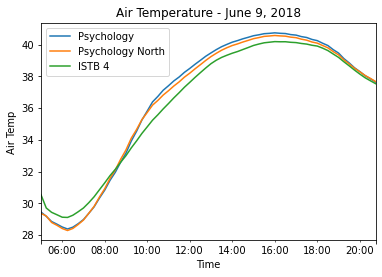

In [24]:
# Air temp plot
fig, ax = plt.subplots()
yplot = 'Air Temp'
ylab = 'Air Temp'
title = 'Air Temperature - June 9, 2018'
Psyc.plot(x = 'Date_Time', y = yplot, label = 'Psychology', xlabel = 'Time', ylabel = ylab, title = title,ax = ax)
Psyc_N.plot(x = 'Date_Time', y = yplot, label = 'Psychology North', xlabel = 'Time', ylabel = ylab, ax = ax)
ISTB4.plot(x = 'Date_Time', y = yplot, label = 'ISTB 4', xlabel = 'Time', ylabel = ylab, ax = ax)

<AxesSubplot:title={'center':'Direct Shortwave (South) - June 9, 2018'}, xlabel='Time', ylabel='DSW South'>

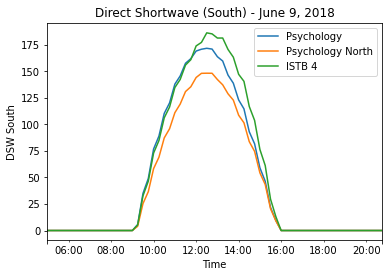

In [25]:
# Direct Shortwave plot
fig, ax = plt.subplots()
yplot = 'DSW South'
ylab = 'DSW South'
title = 'Direct Shortwave (South) - June 9, 2018'
Psyc.plot(x = 'Date_Time', y = yplot, label = 'Psychology', xlabel = 'Time', ylabel = ylab, title = title,ax = ax)
Psyc_N.plot(x = 'Date_Time', y = yplot, label = 'Psychology North', xlabel = 'Time', ylabel = ylab, ax = ax)
ISTB4.plot(x = 'Date_Time', y = yplot, label = 'ISTB 4', xlabel = 'Time', ylabel = ylab, ax = ax)

In [26]:
Psyc

Date_Time  Month  Day  Hour   Air Temp  \
Date_Time                                                              
2018-06-09 05:00:00 2018-06-09 05:00:00      6    9     5  29.455071   
2018-06-09 05:15:00 2018-06-09 05:15:00      6    9     5  29.181743   
2018-06-09 05:30:00 2018-06-09 05:30:00      6    9     5  28.855270   
2018-06-09 05:45:00 2018-06-09 05:45:00      6    9     5  28.689361   
2018-06-09 06:00:00 2018-06-09 06:00:00      6    9     6  28.510102   
...                                 ...    ...  ...   ...        ...   
2018-06-09 19:45:00 2018-06-09 19:45:00      6    9    19  38.548096   
2018-06-09 20:00:00 2018-06-09 20:00:00      6    9    20  38.306907   
2018-06-09 20:15:00 2018-06-09 20:15:00      6    9    20  38.049192   
2018-06-09 20:30:00 2018-06-09 20:30:00      6    9    20  37.850723   
2018-06-09 20:45:00 2018-06-09 20:45:00      6    9    20  37.642339   

                      Abs Hum    DSW Top  DSW North   DSW East  DSW South  \
Date_Time                                                                   
2018-06-09 05:00:00  3.769550   0.000000   0.000000   0.000000        0.0   
2018-06-09 05:15:00  4.391255   0.000000   0.000000   0.000000        0.0   
2018-06-09 05:30:00  4.453515   0.000000   0.000000   0.000000        0.0   
2018-06-09 05:45:00  4.489156   0.594592   0.515791   3.326385        0.0   
2018-06-09 06:00:00  4.635334  24.909085  14.449345  89.797203        0.0   
...                       ...        ...        ...        ...        ...   
2018-06-09 19:45:00  3.344396   0.000000   0.000000   0.000000        0.0   
2018-06-09 20:00:00  3.353782   0.000000   0.000000   0.000000        0.0   
2018-06-09 20:15:00  3.368430   0.000000   0.000000   0.000000        0.0   
2018-06-09 20:30:00  3.399581   0.000000   0.000000   0.000000        0.0   
2018-06-09 20:45:00  3.426417   0.000000   0.000000   0.000000        0.0   

                     ...  Shade North  Shade East  Shade South  Shade West  \
Date_Time            ...                                                     
2018-06-09 05:00:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 05:15:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 05:30:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 05:45:00  ...     0.963265    0.887199          1.0         1.0   
2018-06-09 06:00:00  ...     0.890287    0.759027          1.0         1.0   
...                  ...          ...         ...          ...         ...   
2018-06-09 19:45:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 20:00:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 20:15:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 20:30:00  ...     1.000000    1.000000          1.0         1.0   
2018-06-09 20:45:00  ...     1.000000    1.000000          1.0         1.0   

                         KW  HTmmBTU  CHWTON/SQM  bldgname_ISTB 4  \
Date_Time                                                           
2018-06-09 05:00:00  119.72     0.27    0.023425                0   
2018-06-09 05:15:00  114.22     0.26    0.021138                0   
2018-06-09 05:30:00  113.64     0.25    0.023212                0   
2018-06-09 05:45:00  122.78     0.25    0.024591                0   
2018-06-09 06:00:00  127.57     0.28    0.025143                0   
...                     ...      ...         ...              ...   
2018-06-09 19:45:00  120.78     0.24    0.032658                0   
2018-06-09 20:00:00  121.26     0.24    0.032954                0   
2018-06-09 20:15:00  120.06     0.25    0.034103                0   
2018-06-09 20:30:00  122.46     0.24    0.032992                0   
2018-06-09 20:45:00  122.04     0.23    0.032424                0   

                     bldgname_Psychology  bldgname_Psychology North  
Date_Time                                                            
2018-06-09 05:00:00                   

<AxesSubplot:title={'center':'Shade (South) - June 9, 2018'}, xlabel='Time', ylabel='Shade South'>

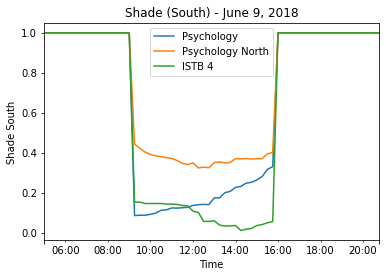

In [27]:
# Shade South plot
fig, ax = plt.subplots()
yplot = 'Shade South'
ylab = 'Shade South'
title = 'Shade (South) - June 9, 2018'
Psyc.plot(x = 'Date_Time', y = yplot, label = 'Psychology', xlabel = 'Time', ylabel = ylab, title = title,ax = ax)
Psyc_N.plot(x = 'Date_Time', y = yplot, label = 'Psychology North', xlabel = 'Time', ylabel = ylab, ax = ax)
ISTB4.plot(x = 'Date_Time', y = yplot, label = 'ISTB 4', xlabel = 'Time', ylabel = ylab, ax = ax)

## 3.2 RandomForests no Tuning

In [28]:
## TRAIN-VALIDATE SPLIT --> FIT RF MODEL --> GET SCORE ##

# 1. Get X and y
dropcols = ['CHWTON/SQM', 'Date_Time', 'Month', 'Hour', 'Day']
X = MD.drop(columns=dropcols)
y = MD['CHWTON/SQM']  
    
# 2. Train-Validate Split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3, random_state=20)

# 3. RF
RF_base = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score = True)

# # 4. Fit model that already has parameters
RF_base.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=42)

In [29]:
X

Air Temp   Abs Hum   DSW Top  DSW North   DSW East  \
Date_Time                                                                  
2018-05-10 05:00:00  25.683514  4.622975  0.000000   0.000000   0.000000   
2018-05-10 05:15:00  25.736349  5.302036  0.000000   0.000000   0.000000   
2018-05-10 05:30:00  25.553062  5.183985  0.000000   0.000000   0.000000   
2018-05-10 05:45:00  25.416068  5.159600  0.000000   0.000000   0.000000   
2018-05-10 06:00:00  25.275380  5.129074  4.955332   3.405959  21.661816   
...                        ...       ...       ...        ...        ...   
2018-07-01 19:45:00  36.654256  3.689179  0.000000   0.000000   0.000000   
2018-07-01 20:00:00  36.482080  3.696157  0.000000   0.000000   0.000000   
2018-07-01 20:15:00  36.297724  3.729496  0.000000   0.000000   0.000000   
2018-07-01 20:30:00  36.115951  3.815479  0.000000   0.000000   0.000000   
2018-07-01 20:45:00  35.894805  3.946143  0.000000   0.000000   0.000000   

                     DSW South  DSW West  Shade North  Shade East  \
Date_Time                                                           
2018-05-10 05:00:00        0.0       0.0      1.00000    1.000000   
2018-05-10 05:15:00        0.0       0.0      1.00000    1.000000   
2018-05-10 05:30:00        0.0       0.0      1.00000    1.000000   
2018-05-10 05:45:00        0.0       0.0      1.00000    1.000000   
2018-05-10 06:00:00        0.0       0.0      0.92746    0.885735   
...                        ...       ...          ...         ...   
2018-07-01 19:45:00        0.0       0.0      1.00000    1.000000   
2018-07-01 20:00:00        0.0       0.0      1.00000    1.000000   
2018-07-01 20:15:00        0.0       0.0      1.00000    1.000000   
2018-07-01 20:30:00        0.0       0.0      1.00000    1.000000   
2018-07-01 20:45:00        0.0       0.0      1.00000    1.000000   

                     Shade South  Shade West      KW  HTmmBTU  \
Date_Time                                                       
2018-05-10 05:00:00          1.0         1.0  111.76     0.14   
2018-05-10 05:15:00          1.0         1.0  108.22     0.14   
2018-05-10 05:30:00          1.0         1.0  107.38     0.17   
2018-05-10 05:45:00          1.0         1.0  121.27     0.16   
2018-05-10 06:00:00          1.0         1.0  123.35     0.15   
...                          ...         ...     ...      ...   
2018-07-01 19:45:00          1.0         1.0   61.63     0.00   
2018-07-01 20:00:00          1.0         1.0   64.75     0.00   
2018-07-01 20:15:00          1.0         1.0   62.42     0.00   
2018-07-01 20:30:00          1.0         1.0   62.94     0.00   
2018-07-01 20:45:00          1.0         1.0   63.10     0.00   

                     bldgname_ISTB 4  bldgname_Psychology  \
Date_Time                                                   
2018-05-10 05:00:00                0                    1   
2018-05-10 05:15:00                0                    1   
2018-05-10 05:30:00                0                    1   
2018-05-10 05:45:00                0                    1   
2018-05-10 06:00:00                0                    1   
...                              ...                  ...   
2018-07-01 19:45:00                0                    0   
2018-07-01 20:00:00                0                    0   
2018-07-01 20:15:00                0                    0   
2018-07-01 20:30:00                0                    0   
2018-07-01 20:45:00                0                    0   

                     bldgname_Psychology North  
Date_Time                                       
2018-05-10 05:00:00                          0  
2018-05-10 05:15:00                          0  
2018-05-10 05:30:00                          0  
2018-05-10 05:45:00                          0  
2018-05-10 06:00:00                          0  
...                                        ...  
2018-07-01 19:45:00                          1  
2018-07-01 20:00:00                          1  
2018-

In [30]:
## FEATURE IMPORTANCE ##
pd.DataFrame({"Features":RF_base.feature_names_in_, 
              "Feature Importance":RF_base.feature_importances_}).sort_values(by='Feature Importance', ascending=False)

Features  Feature Importance
11                         KW            0.586478
0                    Air Temp            0.181901
12                    HTmmBTU            0.150970
14        bldgname_Psychology            0.054601
13            bldgname_ISTB 4            0.005975
3                   DSW North            0.004058
1                     Abs Hum            0.004009
4                    DSW East            0.002466
2                     DSW Top            0.002426
8                  Shade East            0.001547
7                 Shade North            0.001450
15  bldgname_Psychology North            0.001051
9                 Shade South            0.000906
6                    DSW West            0.000903
10                 Shade West            0.000701
5                   DSW South            0.000558

In [31]:
print('criterion: ', RF_base.criterion)
print('max_depth: ', RF_base.max_depth)
print('min_samples_split: ', RF_base.min_samples_split)
print('min_samples_leaf: ', RF_base.min_samples_leaf)
print('min_weight_fraction_leaf: ', RF_base.min_weight_fraction_leaf)
print('max_features: ', RF_base.max_features)
print('max_leaf_nodes: ', RF_base.max_leaf_nodes)
print('min_impurity_decrease: ', RF_base.min_impurity_decrease)
print('random_state: ', RF_base.random_state)
print('ccp_alpha: ', RF_base.ccp_alpha)

criterion:  squared_error
max_depth:  None
min_samples_split:  2
min_samples_leaf:  1
min_weight_fraction_leaf:  0.0
max_features:  1.0
max_leaf_nodes:  None
min_impurity_decrease:  0.0
random_state:  42
ccp_alpha:  0.0


In [32]:
## TEST AND VALIDATION SCORES ##

# Validation Score on All
scoreValidate = RF_base.score(X_validate, y_validate)

# Test Score on All
X_test = J9.drop(columns=dropcols)
Y_test = J9['CHWTON/SQM']
Y_pred = RF_base.predict(X_test)
scoreTest = RF_base.score(X_test, Y_test)

# J
J9B = []
ScoresT = []
for i in ['ISTB 4', 'Psychology', 'Psychology North']:
    b = J9[J9['bldgname_' + i] == 1]
    J9B.append(b)
    X_test = b.drop(columns=dropcols)
    y_test = b['CHWTON/SQM']
    ScoresT.append(RF_base.score(X_test, y_test))

AllBuildingsTest = pd.DataFrame({'Building':['ISTB 4', 'Psychology', 'Psychology North'], 
                                 '[Test Scores (June 9) Individual]': ScoresT,
                                 '[Test Score (June 9) All]' : scoreTest,
                                 '[Validation Score All]': scoreValidate})
AllBuildingsTest

Building  [Test Scores (June 9) Individual]  \
0            ISTB 4                           0.956994   
1        Psychology                           0.751587   
2  Psychology North                           0.802694   

   [Test Score (June 9) All]  [Validation Score All]  
0                   0.968051                0.986171  
1                   0.968051                0.986171  
2                   0.968051                0.986171

In [33]:
### JUNE 9 SENSITIVITY ###

## AIR TEMP AND ABS HUM ##
AirTdelta = -0.5
AbsHdelta = 0
Scen1 = J9.copy()
Scen1['Air Temp'] = Scen1['Air Temp'] + AirTdelta
Scen1['Abs Hum'] = Scen1['Abs Hum'] + AbsHdelta

## SHADING ##
shadred = 0.2

# SINGLE FACADE #
f = 'Shade South'
print("before=>", Scen1[f].unique())
Scen1[f] = Scen1[f] + shadred
Scen1.loc[Scen1[f] > 1, f] = 1
print("after=>", Scen1[f].unique())

# ALL FACADES #
# shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
# for i in shadcol: 
#   Scen1[i] = Scen1[i] + shadred
#   Scen1.loc[Scen1[i] + shadred > 1, i] = 1

X_scentest = Scen1.drop(columns=dropcols)
Y_scenpred = RF_base.predict(X_scentest)


before=> [1.         0.08587736 0.08788455 0.08784754 0.09240728 0.09829387
 0.11262717 0.11460181 0.12425365 0.12319837 0.12533237 0.12735349
 0.13688021 0.14052922 0.14198866 0.1411297  0.17484165 0.17430093
 0.20057154 0.20697678 0.22701888 0.23216026 0.24808976 0.25242091
 0.2639922  0.28089138 0.31710752 0.33097143 0.15340909 0.14630682
 0.14346591 0.14204545 0.13636364 0.13494318 0.10795455 0.10227273
 0.05681818 0.06018214 0.03843152 0.0337101  0.03427149 0.03648271
 0.01129426 0.01795046 0.02142928 0.03620592 0.04084708 0.05014675
 0.05597339 0.44392132 0.42189096 0.40361577 0.39126686 0.38477375
 0.38063098 0.37532868 0.37231549 0.36123843 0.34722812 0.34148719
 0.34974951 0.32420543 0.32820001 0.32544416 0.35113943 0.35476812
 0.34910971 0.35177782 0.37076629 0.36950555 0.37165724 0.36881257
 0.36985524 0.37056605 0.39437135 0.40210202]
after=> [1.         0.28587736 0.28788455 0.28784754 0.29240728 0.29829387
 0.31262717 0.31460181 0.32425365 0.32319837 0.32533237 0.32735349

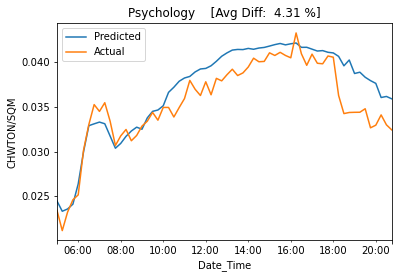

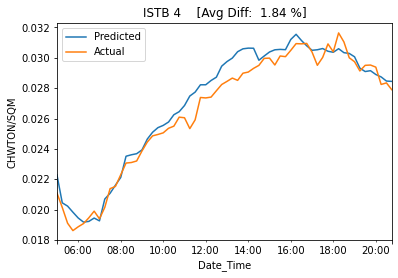

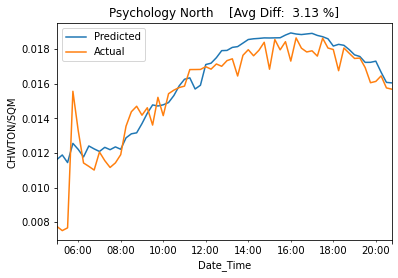

In [34]:
## PREDICTION PLOTS ##
X_test = J9.drop(columns=dropcols)
Y_test = J9['CHWTON/SQM']
Y_pred = RF_base.predict(X_test)
df = X_test.copy()
df['Predicted'] = Y_pred
df['Actual'] = Y_test
df['Scenario'] = Y_scenpred
df = undummify(df)
for i in df['bldgname'].unique():
    b = df[df['bldgname'] == i]
    l = str(round(((b['Predicted'].mean() - 
                    b['Actual'].mean())/b['Actual'].mean())*100,2)) + " %"
    ax = b.plot(y = 'Predicted', label = "Predicted", 
                ylabel = 'CHWTON/SQM', title = i + "    [Avg Diff:  " + l + ']')
    b.plot(y = 'Actual', label = 'Actual', ax=ax)

In [35]:
df.columns

Index(['Air Temp', 'Abs Hum', 'DSW Top', 'DSW North', 'DSW East', 'DSW South',
       'DSW West', 'Shade North', 'Shade East', 'Shade South', 'Shade West',
       'KW', 'HTmmBTU', 'bldgname', 'Predicted', 'Actual', 'Scenario'],
      dtype='object')

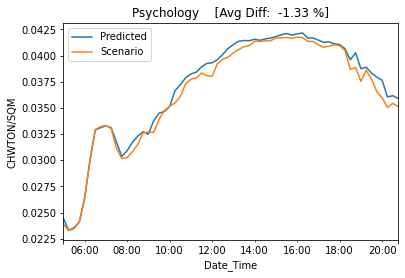

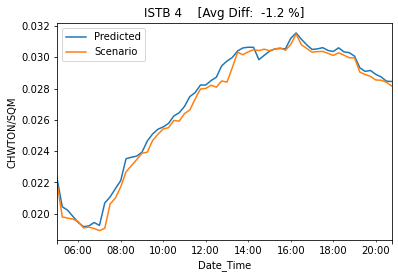

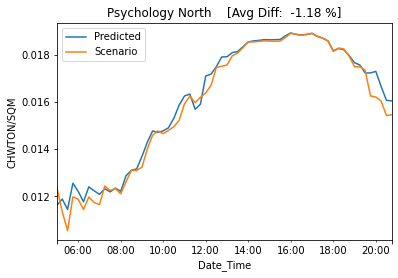

In [36]:
## SCENARIO PLOTS ##
X_test = J9.drop(columns=dropcols)
Y_test = J9['CHWTON/SQM']
Y_pred = RF_base.predict(X_test)
df = X_test.copy()
df['Predicted'] = Y_pred
df['Actual'] = Y_test
df['Scenario'] = Y_scenpred
df = undummify(df)
for i in df['bldgname'].unique():
    b = df[df['bldgname'] == i]
    l = str(round(((b['Scenario'].mean() - 
                    b['Predicted'].mean())/b['Predicted'].mean())*100,2)) + " %"
    ax = b.plot(y = 'Predicted', label = "Predicted", 
                ylabel = 'CHWTON/SQM', title = i + "    [Avg Diff:  " + l + ']')
    b.plot(y = 'Scenario', label = 'Scenario', ax=ax)

## 3.2 Random Forests Tuned

In [37]:
param_test = {'n_estimators': [100,200,300,400],
              'criterion': ['squared_error', 'absolute_error', 'poisson'],
              'max_depth': [None, 100,200,300],
              'max_features': ['auto', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

rf = RandomForestRegressor()
rfgs = RandomizedSearchCV(
    estimator = rf, param_distributions=param_test,
    cv=3,
    refit=True,
    random_state=42,
    verbose=True)
rfgs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [None, 100, 200, 300],
                                        'max_features': ['auto', 'log2', 0.1,
                                                         0.2, 0.3, 0.4, 0.5,
                                                         0.6, 0.7, 0.8, 0.9,
                                                         1],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, verbose=True)

In [38]:
rfgs.best_params_

{'n_estimators': 200,
 'max_features': 0.6,
 'max_depth': None,
 'criterion': 'squared_error'}

In [39]:
RF_tuned = RandomForestRegressor(n_estimators = 400,
                                 max_features = 0.6,
                                 max_depth = 300,
                                 criterion = 'absolute_error')
RF_tuned.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=300,
                      max_features=0.6, n_estimators=400)

In [40]:
## FEATURE IMPORTANCE ##
pd.DataFrame({"Features":RF_tuned.feature_names_in_, 
              "Feature Importance":RF_tuned.feature_importances_}).sort_values(by='Feature Importance', ascending=False)

Features  Feature Importance
11                         KW            0.323985
0                    Air Temp            0.230445
12                    HTmmBTU            0.165106
15  bldgname_Psychology North            0.069134
14        bldgname_Psychology            0.042707
1                     Abs Hum            0.031187
4                    DSW East            0.022390
13            bldgname_ISTB 4            0.019543
6                    DSW West            0.019365
2                     DSW Top            0.017159
10                 Shade West            0.013864
8                  Shade East            0.011859
3                   DSW North            0.010116
7                 Shade North            0.008712
9                 Shade South            0.008095
5                   DSW South            0.006333

In [41]:
print('criterion: ', RF_tuned.criterion)
print('max_depth: ', RF_tuned.max_depth)
print('min_samples_split: ', RF_tuned.min_samples_split)
print('min_samples_leaf: ', RF_tuned.min_samples_leaf)
print('min_weight_fraction_leaf: ', RF_tuned.min_weight_fraction_leaf)
print('max_features: ', RF_tuned.max_features)
print('max_leaf_nodes: ', RF_tuned.max_leaf_nodes)
print('min_impurity_decrease: ', RF_tuned.min_impurity_decrease)
print('random_state: ', RF_tuned.random_state)
print('ccp_alpha: ', RF_tuned.ccp_alpha)

criterion:  absolute_error
max_depth:  300
min_samples_split:  2
min_samples_leaf:  1
min_weight_fraction_leaf:  0.0
max_features:  0.6
max_leaf_nodes:  None
min_impurity_decrease:  0.0
random_state:  None
ccp_alpha:  0.0


In [42]:
## TEST AND VALIDATION SCORES ##

# Validation Score on All
scoreValidate = RF_tuned.score(X_validate, y_validate)

# Test Score on All
X_test = J9.drop(columns=dropcols)
Y_test = J9['CHWTON/SQM']
Y_pred = RF_tuned.predict(X_test)
scoreTest = RF_tuned.score(X_test, Y_test)

# J
J9B = []
ScoresT = []
for i in ['ISTB 4', 'Psychology', 'Psychology North']:
    b = J9[J9['bldgname_' + i] == 1]
    J9B.append(b)
    X_test = b.drop(columns=dropcols)
    y_test = b['CHWTON/SQM']
    ScoresT.append(RF_tuned.score(X_test, y_test))

AllBuildingsTest = pd.DataFrame({'Building':['ISTB 4', 'Psychology', 'Psychology North'], 
                                 '[Test Scores (June 9) Individual]': ScoresT,
                                 '[Test Score (June 9) All]' : scoreTest,
                                 '[Validation Score All]': scoreValidate})
AllBuildingsTest

Building  [Test Scores (June 9) Individual]  \
0            ISTB 4                           0.969517   
1        Psychology                           0.840494   
2  Psychology North                           0.835661   

   [Test Score (June 9) All]  [Validation Score All]  
0                   0.978103                0.986539  
1                   0.978103                0.986539  
2                   0.978103                0.986539

In [43]:
J9B

[                              Date_Time  Month  Day  Hour   Air Temp  \
 Date_Time                                                              
 2018-06-09 05:00:00 2018-06-09 05:00:00      6    9     5  30.547823   
 2018-06-09 05:15:00 2018-06-09 05:15:00      6    9     5  29.707167   
 2018-06-09 05:30:00 2018-06-09 05:30:00      6    9     5  29.434979   
 2018-06-09 05:45:00 2018-06-09 05:45:00      6    9     5  29.283378   
 2018-06-09 06:00:00 2018-06-09 06:00:00      6    9     6  29.127153   
 ...                                 ...    ...  ...   ...        ...   
 2018-06-09 19:45:00 2018-06-09 19:45:00      6    9    19  38.401268   
 2018-06-09 20:00:00 2018-06-09 20:00:00      6    9    20  38.151209   
 2018-06-09 20:15:00 2018-06-09 20:15:00      6    9    20  37.916668   
 2018-06-09 20:30:00 2018-06-09 20:30:00      6    9    20  37.725621   
 2018-06-09 20:45:00 2018-06-09 20:45:00      6    9    20  37.540517   
 
                       Abs Hum    DSW Top  DSW No

## 3.3 Sensitivity

In [44]:
### JUNE 9 SENSITIVITY ###

## AIR TEMP AND ABS HUM ##
AirTdelta = -0.5
AbsHdelta = -0.5
Scen1 = J9.copy()
Scen1['Air Temp'] = Scen1['Air Temp'] + AirTdelta
Scen1['Abs Hum'] = Scen1['Abs Hum'] + AbsHdelta

## SHADING ##
shadred = 0.5

# SINGLE FACADE #
# f = 'Shade South'
# Scen1[f] = Scen1[f] + shadred
# Scen1.loc[Scen1[f] > 1, f] = 1

# ALL FACADES #
shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
for i in shadcol: 
    Scen1[i] = Scen1[i] + shadred
    Scen1.loc[Scen1[i] + shadred > 1, i] = 1


X_scentest = Scen1.drop(columns=dropcols)
Y_scenpred = RF_tuned.predict(X_scentest)

                      Air Temp   Abs Hum    DSW Top  DSW North   DSW East  \
Date_Time                                                                   
2018-06-09 05:00:00  29.455071  3.769550   0.000000   0.000000   0.000000   
2018-06-09 05:15:00  29.181743  4.391255   0.000000   0.000000   0.000000   
2018-06-09 05:30:00  28.855270  4.453515   0.000000   0.000000   0.000000   
2018-06-09 05:45:00  28.689361  4.489156   0.594592   0.515791   3.326385   
2018-06-09 06:00:00  28.510102  4.635334  24.909085  14.449345  89.797203   
...                        ...       ...        ...        ...        ...   
2018-06-09 19:45:00  38.548096  3.344396   0.000000   0.000000   0.000000   
2018-06-09 20:00:00  38.306907  3.353782   0.000000   0.000000   0.000000   
2018-06-09 20:15:00  38.049192  3.368430   0.000000   0.000000   0.000000   
2018-06-09 20:30:00  37.850723  3.399581   0.000000   0.000000   0.000000   
2018-06-09 20:45:00  37.642339  3.426417   0.000000   0.000000   0.000000   

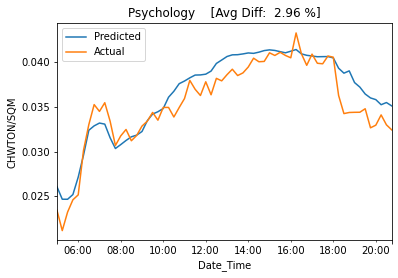

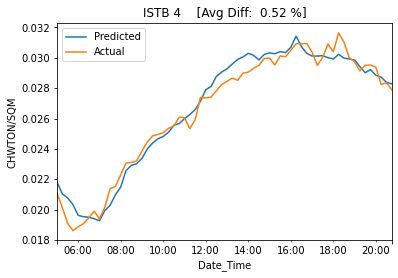

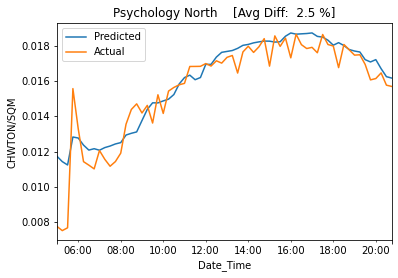

In [45]:
## PREDICTION PLOTS ##
X_test = J9.drop(columns=dropcols)
Y_test = J9['CHWTON/SQM']
Y_pred = RF_tuned.predict(X_test)
df = X_test.copy()
df['Predicted'] = Y_pred
df['Actual'] = Y_test
df['Scenario'] = Y_scenpred
df = undummify(df)
blist = []
for i in df['bldgname'].unique():
    b = df[df['bldgname'] == i]
    print(b)
    blist.append(b)
    l = str(round(((b['Predicted'].mean() - 
                    b['Actual'].mean())/b['Actual'].mean())*100,2)) + " %"
    ax = b.plot(y = 'Predicted', label = "Predicted", 
                ylabel = 'CHWTON/SQM', title = i + "    [Avg Diff:  " + l + ']')
    b.plot(y = 'Actual', label = 'Actual', ax=ax)

<AxesSubplot:title={'center':'Psychology North    [Avg Diff:  2.5 %]'}, xlabel='Date_Time', ylabel='CHWTON/SQM'>

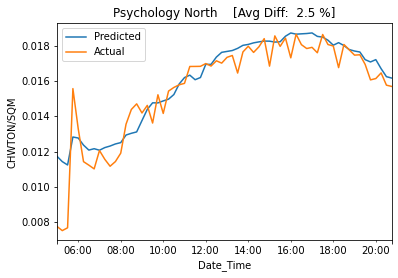

In [46]:
b = blist[2]

l = str(round(((b['Predicted'].mean() - 
                b['Actual'].mean())/b['Actual'].mean())*100,2)) + " %"
ax = b.plot(y = 'Predicted', label = "Predicted", 
            ylabel = 'CHWTON/SQM', title = b['bldgname'][0] + "    [Avg Diff:  " + l + ']')
b.plot(y = 'Actual', label = 'Actual', ax=ax)

<AxesSubplot:xlabel='Date_Time'>

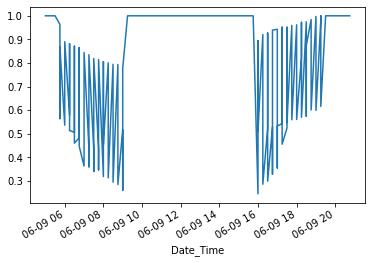

In [47]:
X_test['Shade North'].plot()

<AxesSubplot:xlabel='Date_Time'>

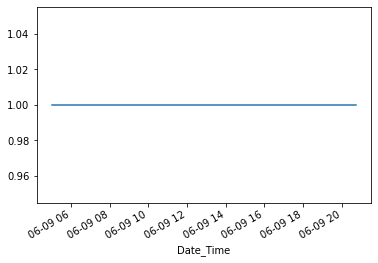

In [48]:
X_scentest['Shade North'].plot()

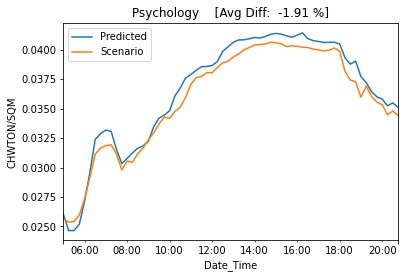

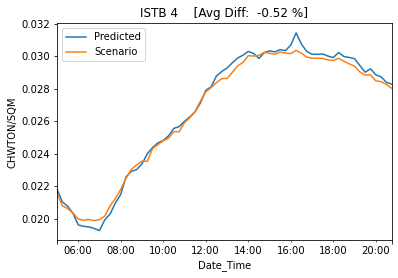

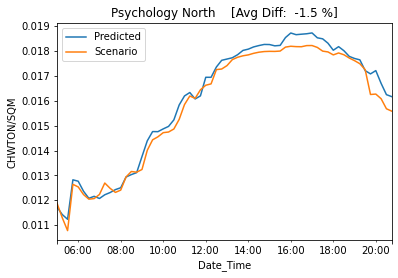

In [49]:
## SCENARIO PLOTS ##
X_test = J9.drop(columns=dropcols)
Y_test = J9['CHWTON/SQM']
Y_pred = RF_tuned.predict(X_test)
df = X_test.copy()
df['Predicted'] = Y_pred
df['Actual'] = Y_test
df['Scenario'] = Y_scenpred
df = undummify(df)
blist = []
for i in df['bldgname'].unique():
    b = df[df['bldgname'] == i]
    blist.append(b)
    l = str(round(((b['Scenario'].mean() - 
                    b['Predicted'].mean())/b['Predicted'].mean())*100,2)) + " %"
    ax = b.plot(y = 'Predicted', label = "Predicted", 
                ylabel = 'CHWTON/SQM', title = i + "    [Avg Diff:  " + l + ']')
    b.plot(y = 'Scenario', label = 'Scenario', ax=ax)

<AxesSubplot:title={'center':'Psychology North    [Avg Diff:  -1.5 %]'}, xlabel='Date_Time', ylabel='CHWTON/SQM'>

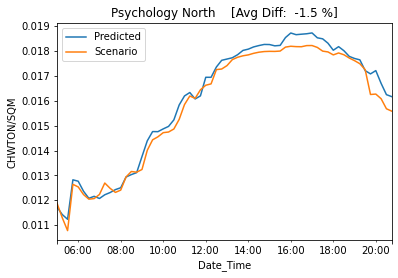

In [50]:
b = blist[2]
i = b['bldgname'][0]
l = str(round(((b['Scenario'].mean() - 
                b['Predicted'].mean())/b['Predicted'].mean())*100,2)) + " %"
ax = b.plot(y = 'Predicted', label = "Predicted", 
            ylabel = 'CHWTON/SQM', title = i + "    [Avg Diff:  " + l + ']')
b.plot(y = 'Scenario', label = 'Scenario', ax=ax)

## 3.4 Model Interpretation: SHAP

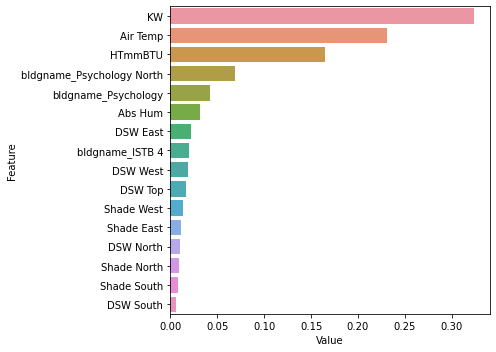

In [51]:
## Using Feature Importance
feature_imp= pd.DataFrame(sorted(zip(RF_tuned.feature_importances_, X_train.columns), reverse = True), columns = ['Value', 'Feature'])

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp[:20].sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()

In [52]:
import math
from sklearn.metrics import r2_score, mean_squared_error

In [53]:
def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_pred-y_true)
    mbe = diff.mean()
    print('MBE = ', mbe)

In [54]:
pred = RF_base.predict(X_test)
r2 = r2_score(Y_test, pred)
rmse = math.sqrt(mean_squared_error(Y_test, pred))
MBE(Y_test, pred)
print("r2 score: ", r2)
print("rmse score: ", rmse)

MBE =  0.0008348707638015955
r2 score:  0.9680511921094246
rmse score:  0.0016061374093891423


In [55]:
# pred

In [56]:
pred = RF_tuned.predict(X_test)
r2 = r2_score(Y_test, pred)
rmse = math.sqrt(mean_squared_error(Y_test, pred))
MBE(Y_test, pred)
print("tuned r2 score: ", r2)
print("tuned rmse score: ", rmse)

MBE =  0.0005243808854419997
tuned r2 score:  0.9781033340661884
tuned rmse score:  0.0013296715143836261


In [57]:
# !pip3 install shap
import shap

explainer = shap.TreeExplainer(model=RF_base,
                               data=None,
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

shap_values = explainer.shap_values(X_test)

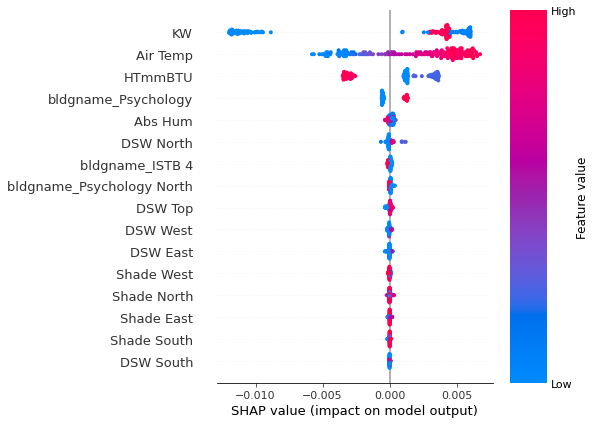

In [58]:
# visualize the first prediction's explanation
shap.initjs()
i = 7
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_size = [8,6], show = False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)

# imported notedbook

In [93]:
TRAIN_PATH = "././Data/microclimate_model/Combined/three_bldgs_dropped.csv"
TEST_PATH = "././Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"

In [94]:
"""
This class encapsulates the datas that we will need for training and testing.
It only contains getters for the train and test data
"""
class Data(object):
    def __init__(self, train_path, test_path, isDropISTB = True):
        """
        Parameters:
            train_path (str) : The file path for the trainning csv file. 
            test_path (str) : The path for the test csv file. 
        
        Both train and test datas have 16 columns with buildings already encoded
        """
        dropped_cols = ['CHWTON/SQM', "bldgname_ISTB 4"]
        if not isDropISTB:
            dropped_cols = ['CHWTON/SQM']
            
        # - Train and validation data
        self.train_val_df = pd.read_csv(train_path, index_col=0)
        self.X_train_val = self.train_val_df.drop(columns=dropped_cols)
        self.y_train_val = self.train_val_df['CHWTON/SQM']  
        
        # - Test data
        self.test_df = pd.read_csv(test_path, index_col=0)
        self.X_test = self.test_df.drop(columns=dropped_cols)
        self.y_test = self.test_df['CHWTON/SQM'] 
        
    
    def get_xy_trainval(self):
        """
        Return the X and y for training data which we can split to train and validation data later.
        """
        return self.X_train_val, self.y_train_val
    
    def get_xy_test(self):
        """
        Return the X and y for June 9th test data
        """
        return self.X_test, self.y_test

In [95]:

"""
This class encapsulates the the training and testing process.
It stores the train and test datas that's already split to X and y
"""
class TrainTest(object):
    def __init__(self, X_train_val, y_train_val, X_test, y_test):
        # - scores_df to display the scores for all our models
        self.columns=['model','r2_val', 'r2_test', 'rmse_test','mbe_test']
        self.scores_df= pd.DataFrame(columns=self.columns)
        
        # - train and test data
        self.X_train_val = X_train_val
        self.y_train_val = y_train_val
        self.X_test = X_test
        self.y_test = y_test
    
    def get_scores_df(self):
        return self.scores_df
    
    
    def train_and_store_score(self, model, model_name):
        """
        This function will train the model given as parameter using the training data. It will compute the r2 validation score
        and append this as a new row to scores_df.
        
        Parameters:
            model (regressor model) : The model object that will be trained and used in validation.
                It can be RF, XGB, LGBM, or catboost regressor
                
            model_name (str) : the name of the model displayed in scores_df
        """
        # 1. Train-Val Split
        X_train, X_val, y_train, y_val = train_test_split(self.X_train_val, 
                                                          self.y_train_val, 
                                                          test_size=0.3, 
                                                          random_state=20)

        # 2. fit model that already has parameters
        model.fit(X_train, y_train)


        # - Get best params if it's a random or grid search
        # if("random" in pModelName) or ("grid" in pModelName):
        #     print(pModel.best_estimator_.get_params())
        
        
        # 3. get validation R2 score
        val_r2 = model.score(X_val, y_val)
        
        # 4. store score
        new_row_data = {'model':model_name, "r2_val":val_r2, "r2_test":0, 'rmse_test':0, 'mbe_test':0}
        new_row = pd.DataFrame.from_records([new_row_data])
        self.scores_df = pd.concat([self.scores_df, new_row])

    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe

        
    def test_and_store_score(self, model, model_name):
        """
        This function will use the given trained model to compute the y_pred using the X_test data.
        It will then compute the mbe, r2, and rmse result and insert it to scores_df. 
        
        Parameters:
            model (regressor model): The model that has been trained and will be used to predict y using the test data
                It can be RF, XGB, LGBM, or catboost regressor
            model_name (string): the name of the model displayed in scores_df
        
        """
        # 1. Get prediction for the test data
        y_pred = model.predict(self.X_test)
        
        # 2. get the three scores
        r2 = r2_score(self.y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(self.y_test, y_pred))
        mbe = self.get_MBE(self.y_test, y_pred)
        
        # 3. update scores_df with the 3 scores above
        row_to_update = self.scores_df["model"] == model_name
        col_to_update = ['r2_test','rmse_test', 'mbe_test']
        self.scores_df.loc[row_to_update, col_to_update] = [r2, rmse, mbe]
        
        # print("r2:", r2)
        # print("rmse:", rmse)
        # print("mbe:", mbe)

In [96]:
# def main():
# get datas train_val and test
data_obj = Data(TRAIN_PATH, TEST_PATH)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test = data_obj.get_xy_test()

# - init the trainTest object
tt = TrainTest(X_train_val, y_train_val,X_test, y_test)

In [97]:
# Load model
import pickle

MODEL_PATH = "./microclimate_model/cb_best.sav"
cb_name = "cb_best"
cb_best = pickle.load(open(MODEL_PATH, 'rb'))



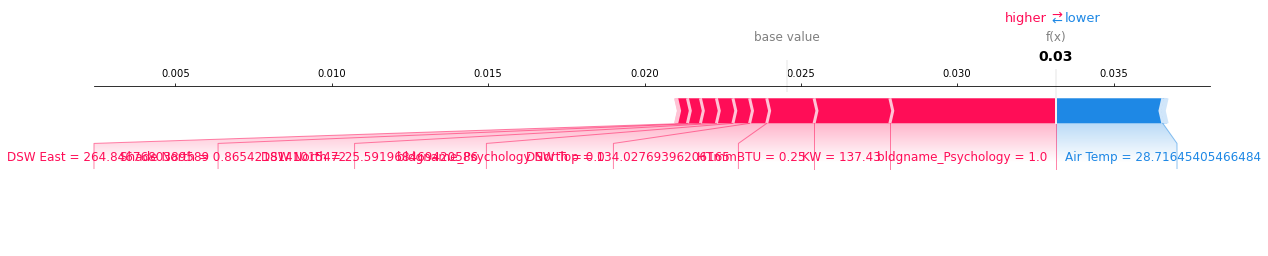

In [98]:

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
explainer = shap.TreeExplainer(model=cb_best,
                           data=None,
                           model_output='raw',
                           feature_perturbation='tree_path_dependent'
                              )
shap_values = explainer.shap_values(X_test)


# visualize the first prediction's explanation
shap.initjs()
i = 7
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], matplotlib = True)

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)



